In [189]:
# ML assignment 1 - HWS 2021
# Timur Michael Carstensen
# Student ID: 1722194

In [4]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
from mnist import MNIST  # run from Anaconda shell: pip install python-mnist
from collections import Counter
import sklearn
import sklearn.metrics
from sklearn.model_selection import KFold
from IPython import get_ipython

%matplotlib notebook


def nextplot():
    inNotebook = "IPKernelApp" in get_ipython().config
    if inNotebook:
        plt.figure()  # this creates a new plot
    else:
        plt.clf()  # and this clears the current one

# Load the data

In [5]:
mndata = MNIST("data/")
X, y = mndata.load_training()
y = np.array(y, dtype="uint8")
X = np.array([np.array(x) for x in X], dtype="uint8")
N, D = X.shape
Xtest, ytest = mndata.load_testing()
ytest = np.array(ytest, dtype="uint8")
Xtest = np.array([np.array(x) for x in Xtest], dtype="uint8")
Ntest = Xtest.shape[0]

In [150]:
# Optional: use a smaller sample of the data
p = np.zeros(0, dtype="int")
for c in range(10):
    p = np.append(p, np.random.choice(np.where(y == c)[0], size=100, replace=False))
X_s = X[p, :]
y_s = y[p]
N_s = X_s.shape[0]
p = np.zeros(0, dtype="int")
for c in range(10):
    p = np.append(p, np.random.choice(np.where(ytest == c)[0], size=10, replace=False))
Xtest_s = Xtest[p, :]
ytest_s = ytest[p]
Ntest_s = Xtest_s.shape[0]

In [151]:
def showdigit(x):
    "Show one digit as a gray-scale image."
    plt.imshow(x.reshape(28, 28), norm=mpl.colors.Normalize(0, 255), cmap="gray")

<IPython.core.display.Javascript object>


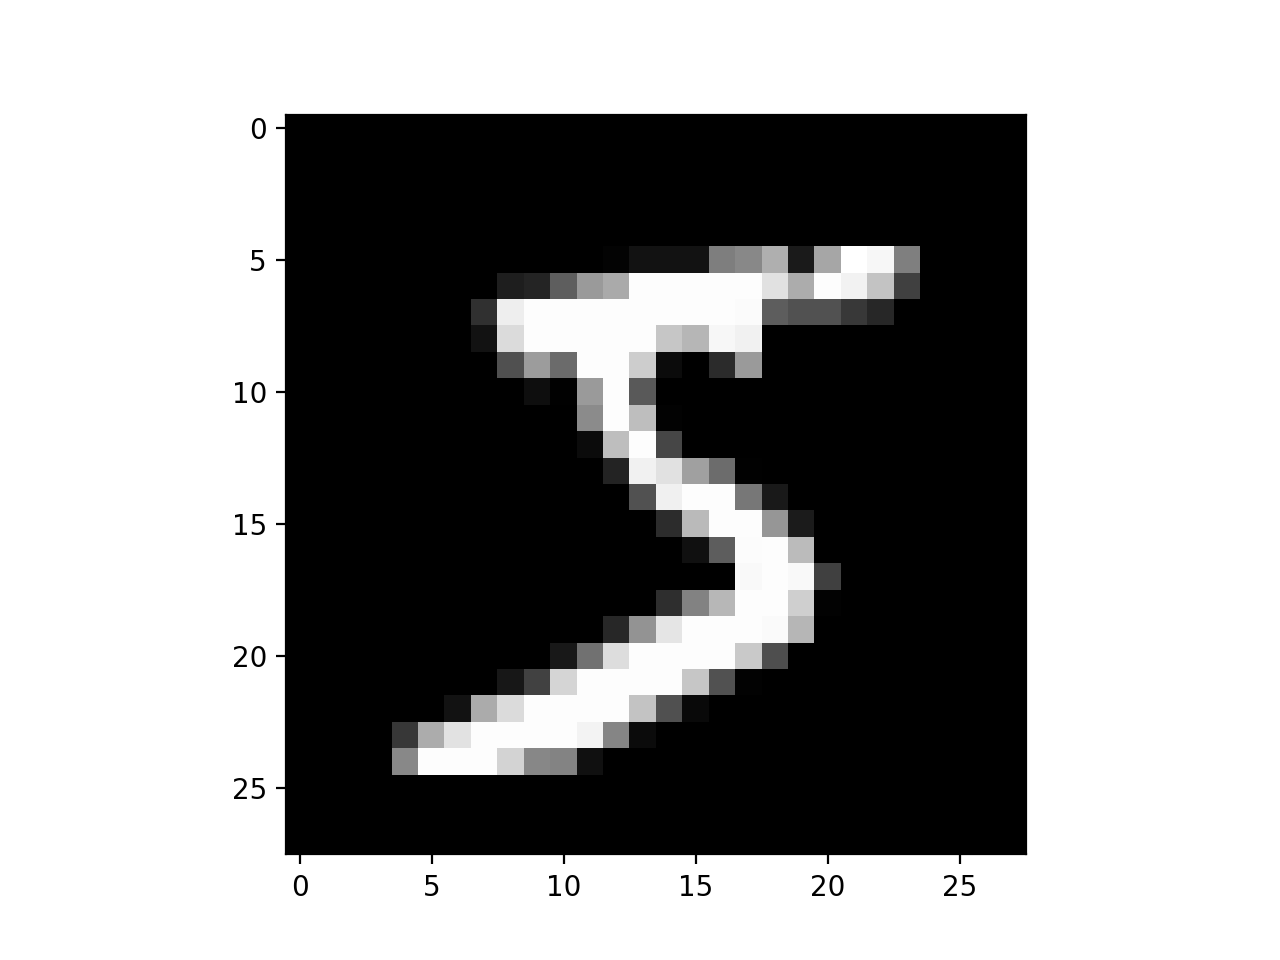

5


In [152]:
# Example: show first digit
nextplot()
showdigit(X[0,])
print(y[0])

In [153]:
def showdigits(X, y, max_digits=15):
    "Show up to max_digits random digits per class from X with class labels from y."
    num_cols = min(max_digits, max(Counter(y).values()))
    for c in range(10):
        ii = np.where(y == c)[0]
        if len(ii) > max_digits:
            ii = np.random.choice(ii, size=max_digits, replace=False)
        for j in range(num_cols):
            ax = plt.gcf().add_subplot(
                10, num_cols, c * num_cols + j + 1, aspect="equal"
            )
            ax.get_xaxis().set_visible(False)
            if j == 0:
                ax.set_ylabel(c)
                ax.set_yticks([])
            else:
                ax.get_yaxis().set_visible(False)
            if j < len(ii):
                ax.imshow(
                    X[ii[j],].reshape(28, 28),
                    norm=mpl.colors.Normalize(0, 255),
                    cmap="gray",
                )
            else:
                ax.axis("off")

<IPython.core.display.Javascript object>


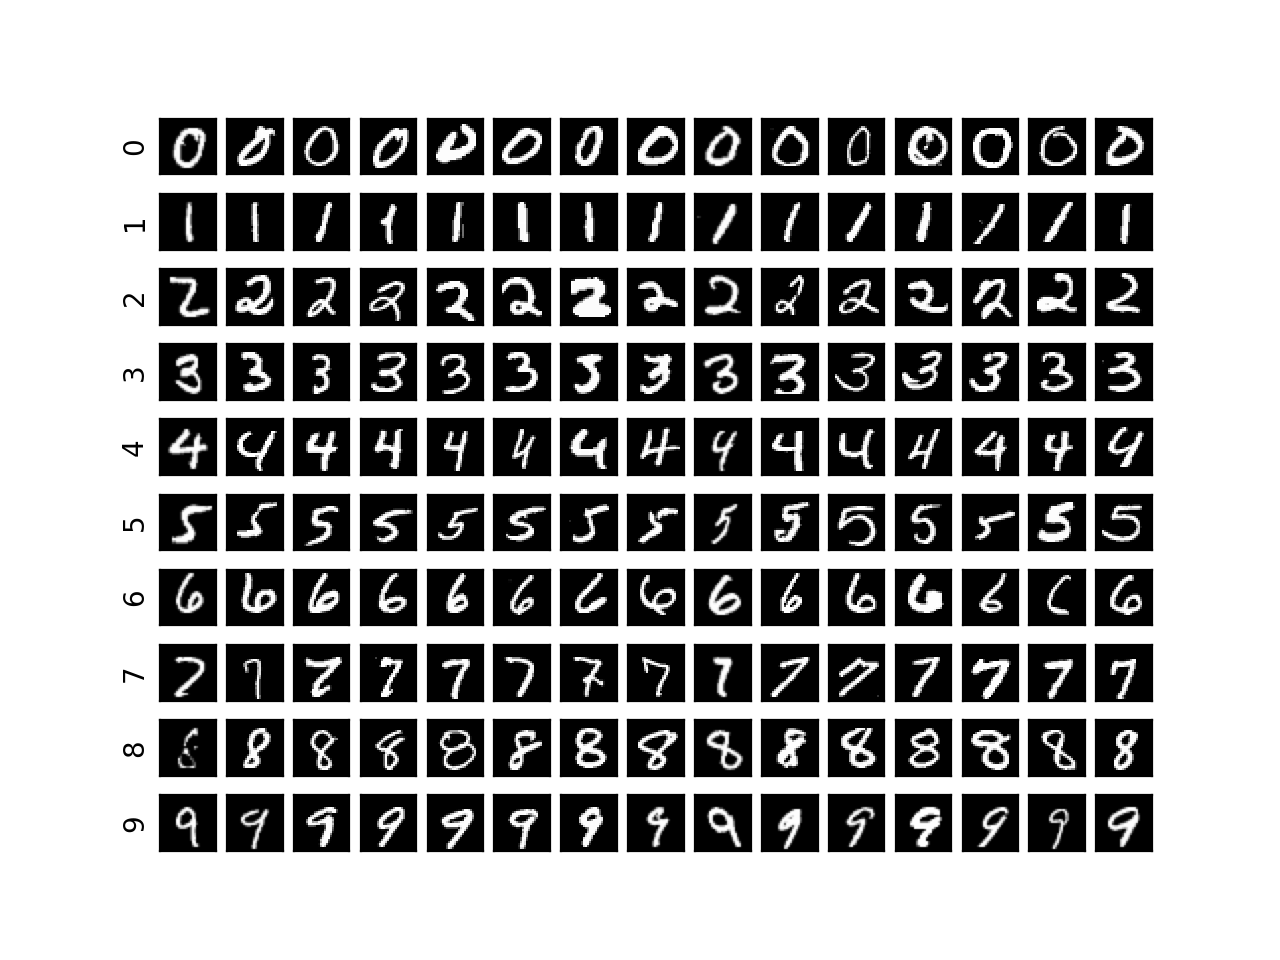

In [154]:
# Example: show 15 random digits per class from training data
nextplot()
showdigits(X, y)

<IPython.core.display.Javascript object>


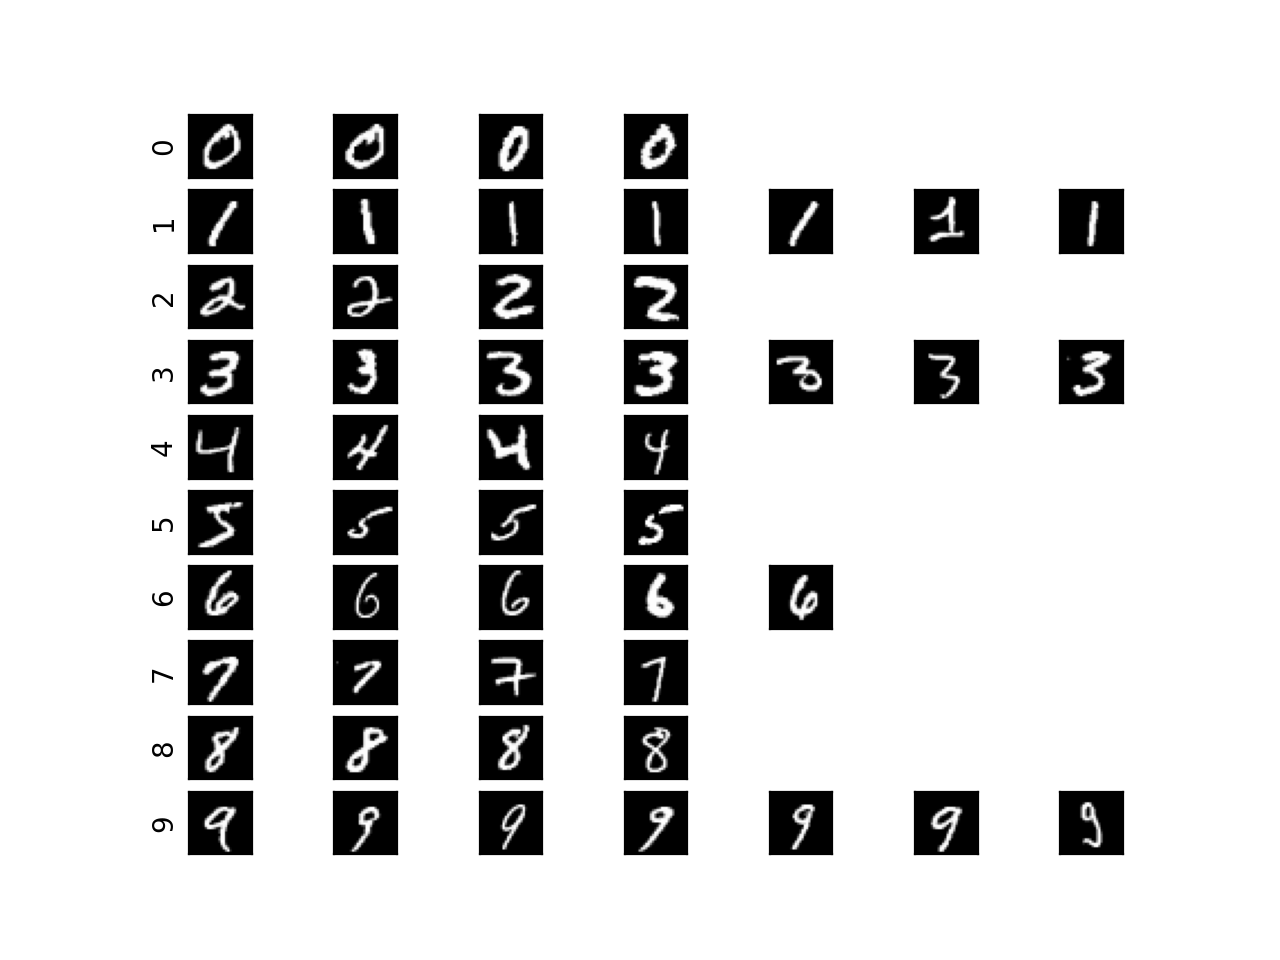

In [155]:
# Example: show a specific set of digits
nextplot()
showdigits(X[0:50,], y[0:50])

In [6]:
# A simple example dataset that you can use for testing
Xex = np.array([1, 0, 0, 1, 1, 1, 2, 0]).reshape(4, 2)
yex = np.array([0, 1, 2, 0])

# 1 Training

In [7]:
def nb_train(X, y, alpha=1, K=None, C=None):
    """Train a Naive Bayes model.

    We assume that all features are encoded as integers and have the same domain
    (set of possible values) from 0:(K-1). Similarly, class labels have domain
    0:(C-1).

    Parameters
    ----------
    X : ndarray of shape (N,D)
        Design matrix.
    y : ndarray of shape (N,)
        Class labels.
    alpha : int
        Parameter for symmetric Dirichlet prior (Laplace smoothing) for all
        fitted distributions.
    K : int
        Each feature takes values in [0,K-1]. None means auto-detect.
    C : int
        Each class label takes values in [0,C-1]. None means auto-detect.

    Returns
    -------
    A dictionary with the following keys and values:

    logpriors : ndarray of shape (C,)
        Log prior probabilities of each class such that logpriors[c] contains
        the log prior probability of class c.

    logcls : ndarray of shape(C,D,K)
        A class-by-feature-by-value array of class-conditional log-likelihoods
        such that logcls[c,j,v] contains the conditional log-likelihood of value
        v in feature j given class c.
    """
    N, D = X.shape
    if K is None:
        K = np.max(X) + 1
    if C is None:
        C = np.max(y) + 1

    # Compute class priors and store them in priors
    priors = np.zeros(C)
    # YOUR CODE HERE
    density = np.zeros(C)
    for i in y:
        density[i] += 1
        
    for c in range(C):                  # calculating priors as a function of the # of occurrences 
                                        # of each class, alpha, total #samples (N) and # classes (C)
        priors[c] = (density[c] + (alpha - 1) ) / (N + (C * (alpha - 1))) 

    # Compute class-conditional densities in a class x feature x value array
    # and store them in cls.
    class_conditional_densities = np.zeros((C, D, K))
    # YOUR CODE HERE

    n_cjk = np.zeros((C, D, K))         # corresponds to the cube in the report
    for c in range(C):                  # for all classes
        x_sub = X[np.where(y == c)]     # x_sub is a subset of X where all elements belong to class c 
        for x_s in x_sub:               # for all samples of class c
            for d in range(D):          # for all features of a sample from class c
                n_cjk[c,d, x_s[d]] += 1 # incrementing the amount of times we have seen a 
                                        # particular pixel taking a certain intensity

    for c in range(C):                  # likelihood function as per report
        for d in range(D):              # same approach as for the priors but instead of the number if classes (C)
            for k in range(K):          # the number of possible values the features can take is used (K)
                class_conditional_densities[c,d,k] = (n_cjk[c,d,k] + (alpha - 1)) / (density[c] + ((alpha - 1) * K)) 
                
    # Output result
    return dict(logcls = np.log(class_conditional_densities), logpriors = np.log(priors))

In [8]:
# Test your code (there should be a warning when you run this)
model = nb_train(Xex, yex, alpha=1)
model
# This should produce:
# {'logcls': array([[[       -inf, -0.69314718, -0.69314718],
#          [ 0.        ,        -inf,        -inf]],
#
#         [[ 0.        ,        -inf,        -inf],
#          [       -inf,  0.        ,        -inf]],
#
#         [[       -inf,  0.        ,        -inf],
#          [       -inf,  0.        ,        -inf]]]),
#  'logpriors': array([-0.69314718, -1.38629436, -1.38629436])}

<ipython-input-7-93eb4937b693>:71: RuntimeWarning: divide by zero encountered in log
  return dict(logcls = np.log(class_conditional_densities), logpriors = np.log(priors))


{'logcls': array([[[       -inf, -0.69314718, -0.69314718],
         [ 0.        ,        -inf,        -inf]],
 
        [[ 0.        ,        -inf,        -inf],
         [       -inf,  0.        ,        -inf]],
 
        [[       -inf,  0.        ,        -inf],
         [       -inf,  0.        ,        -inf]]]),
 'logpriors': array([-0.69314718, -1.38629436, -1.38629436])}

In [158]:
# Test your code (this time no warning)
model = nb_train(Xex, yex, alpha=2)  # add-one smoothing
model
# This should produce:
# {'logcls': array([[[-1.60943791, -0.91629073, -0.91629073],
#          [-0.51082562, -1.60943791, -1.60943791]],
#
#         [[-0.69314718, -1.38629436, -1.38629436],
#          [-1.38629436, -0.69314718, -1.38629436]],
#
#         [[-1.38629436, -0.69314718, -1.38629436],
#          [-1.38629436, -0.69314718, -1.38629436]]]),
#  'logpriors': array([-0.84729786, -1.25276297, -1.25276297])}

{'logcls': array([[[-1.60943791, -0.91629073, -0.91629073],
         [-0.51082562, -1.60943791, -1.60943791]],
 
        [[-0.69314718, -1.38629436, -1.38629436],
         [-1.38629436, -0.69314718, -1.38629436]],
 
        [[-1.38629436, -0.69314718, -1.38629436],
         [-1.38629436, -0.69314718, -1.38629436]]]),
 'logpriors': array([-0.84729786, -1.25276297, -1.25276297])}

In [159]:
# Full model with alpha=1 and alpha=2
model_alpha_1 = nb_train(X, y, alpha = 1)  
model_alpha_2 = nb_train(X, y, alpha = 2) # here we use add-one smoothing

In [160]:
model_alpha_1

{'logcls': array([[[  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         ...,
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf]],
 
        [[  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         ...,
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf]],
 
        [[  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         ...,
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf]],
 
   

In [161]:
model_alpha_2

{'logcls': array([[[-0.04214455, -8.72891173, -8.72891173, ..., -8.72891173,
          -8.72891173, -8.72891173],
         [-0.04214455, -8.72891173, -8.72891173, ..., -8.72891173,
          -8.72891173, -8.72891173],
         [-0.04214455, -8.72891173, -8.72891173, ..., -8.72891173,
          -8.72891173, -8.72891173],
         ...,
         [-0.04214455, -8.72891173, -8.72891173, ..., -8.72891173,
          -8.72891173, -8.72891173],
         [-0.04214455, -8.72891173, -8.72891173, ..., -8.72891173,
          -8.72891173, -8.72891173],
         [-0.04214455, -8.72891173, -8.72891173, ..., -8.72891173,
          -8.72891173, -8.72891173]],
 
        [[-0.03711946, -8.85337967, -8.85337967, ..., -8.85337967,
          -8.85337967, -8.85337967],
         [-0.03711946, -8.85337967, -8.85337967, ..., -8.85337967,
          -8.85337967, -8.85337967],
         [-0.03711946, -8.85337967, -8.85337967, ..., -8.85337967,
          -8.85337967, -8.85337967],
         ...,
         [-0.03711946, 

# 2 Prediction

In [162]:
def logsumexp(x):
    """Computes log(sum(exp(x)).

    Uses offset trick to reduce risk of numeric over- or underflow. When x is a
    1D ndarray, computes logsumexp of its entries. When x is a 2D ndarray,
    computes logsumexp of each column.

    Keyword arguments:
    x : a 1D or 2D ndarray
    """
    offset = np.max(x, axis=0)
    return offset + np.log(np.sum(np.exp(x - offset), axis=0))

In [190]:
def nb_predict(model, Xnew):
    """Predict using a Naive Bayes model.

    Parameters
    ----------
    model : dict
        A Naive Bayes model trained with nb_train.
    Xnew : nd_array of shape (Nnew,D)
        New data to predict.

    Returns
    -------
    A dictionary with the following keys and values:

    yhat : nd_array of shape (Nnew,)
        Predicted label for each new data point.

    logprob : nd_array of shape (Nnew,)
        Log-probability of the label predicted for each new data point.
    """
    logpriors = model["logpriors"]
    logcls = model["logcls"]
    Nnew = Xnew.shape[0]
    C, D, K = logcls.shape

    # Compute the unnormalized log joint probabilities P(Y=c, x_i) of each
    # test point (row i) and each class (column c); store in logjoint
    logjoint = np.zeros((Nnew, C))

    for x in range(Nnew):           # implementation of the log-space posterior predictive function to 
        for c in range(C):          # calculate the matrix of joint probabilities 
            logjoint[x,c] = logpriors[c] + np.sum([logcls[c,d, Xnew[x][d]] for d in range(D)]) 

    # Compute predicted labels (in "yhat") and their log probabilities
    # P(yhat_i | x_i) (in "logprob")

    yhat = np.zeros((Nnew))
    logprob = np.zeros((Nnew))
    logjoint_res = np.zeros((Nnew, C))
    
    for x in range(Nnew):            # shifting all values using the LogSumExp-trick
        logjoint_res[x] = [logjoint[x][c] - logsumexp(logjoint[x]) for c in range(C)] 
    
    for y_i in range(len(yhat)): 
        yhat[y_i] = np.argmax(logjoint_res[y_i]) # predicting the class with the highest probability for each example
        logprob[y_i] = np.max(logjoint_res[y_i]) # storing the probability predicted of the predicted class label

    return dict(yhat=yhat, logprob=logprob)

In [191]:
# Test your code
model = nb_train(Xex, yex, alpha=2)
nb_predict(model, Xex)
# This should produce:
# {'logprob': array([-0.41925843, -0.55388511, -0.68309684, -0.29804486]),
#  'yhat': array([0, 1, 2, 0], dtype=int64)}

{'yhat': array([0., 1., 2., 0.]),
 'logprob': array([-0.41925843, -0.55388511, -0.68309684, -0.29804486])}

# 3 Experiments on MNIST Digits Data

In [165]:
# Let's train the model on the digits data and predict
np.seterr(divide='ignore')
model_nb2 = nb_train(X, y, alpha=2)
pred_nb2 = nb_predict(model_nb2, Xtest)
yhat = pred_nb2["yhat"]
logprob = pred_nb2["logprob"]

In [166]:
# Accuracy
sklearn.metrics.accuracy_score(ytest, yhat)

0.8363

<IPython.core.display.Javascript object>


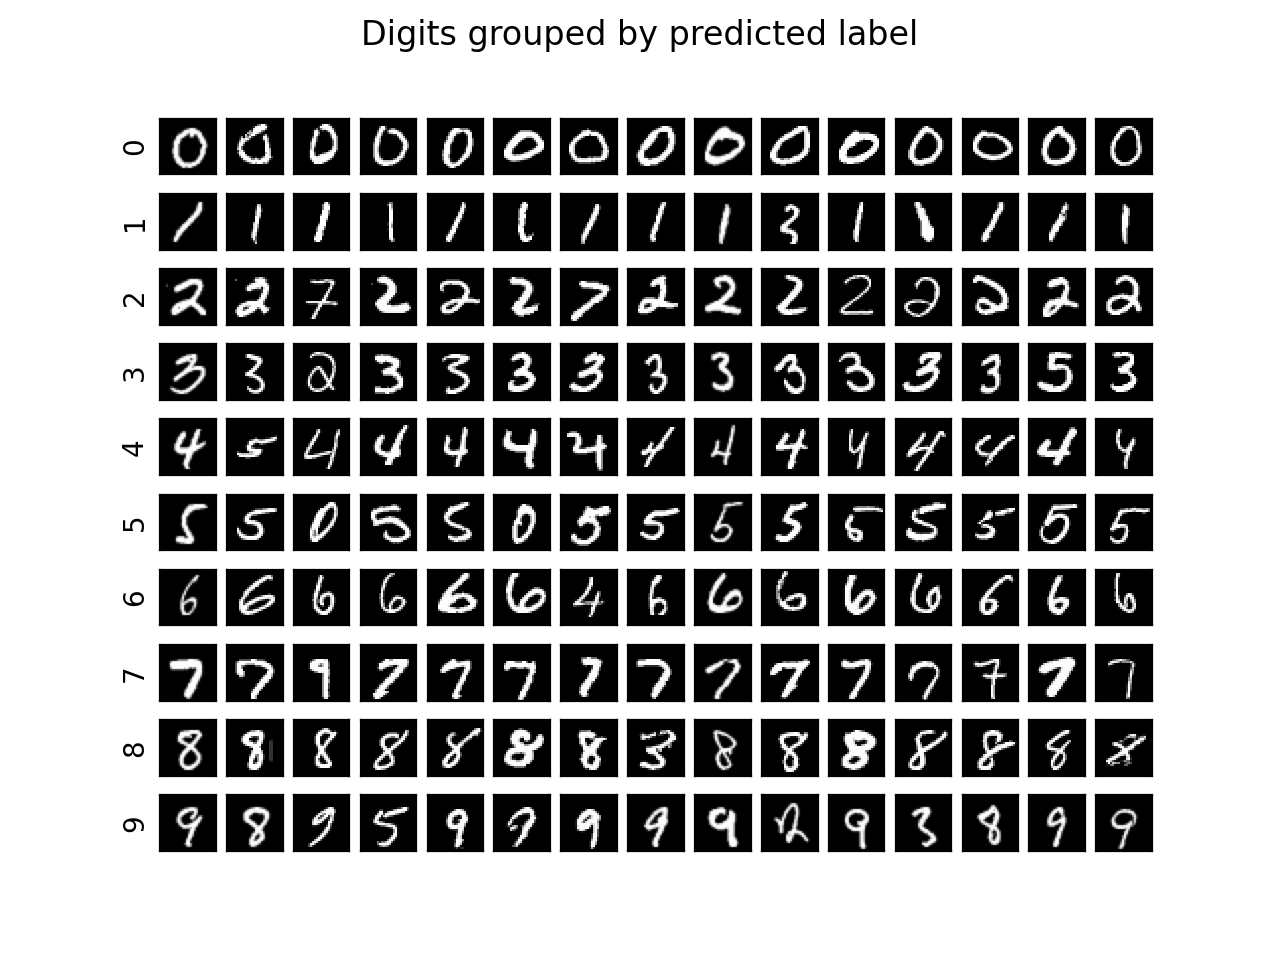

Text(0.5, 0.98, 'Digits grouped by predicted label')

In [183]:
# show some digits grouped by prediction; can you spot errors?
nextplot()
showdigits(Xtest, yhat)
plt.suptitle("Digits grouped by predicted label")

<IPython.core.display.Javascript object>


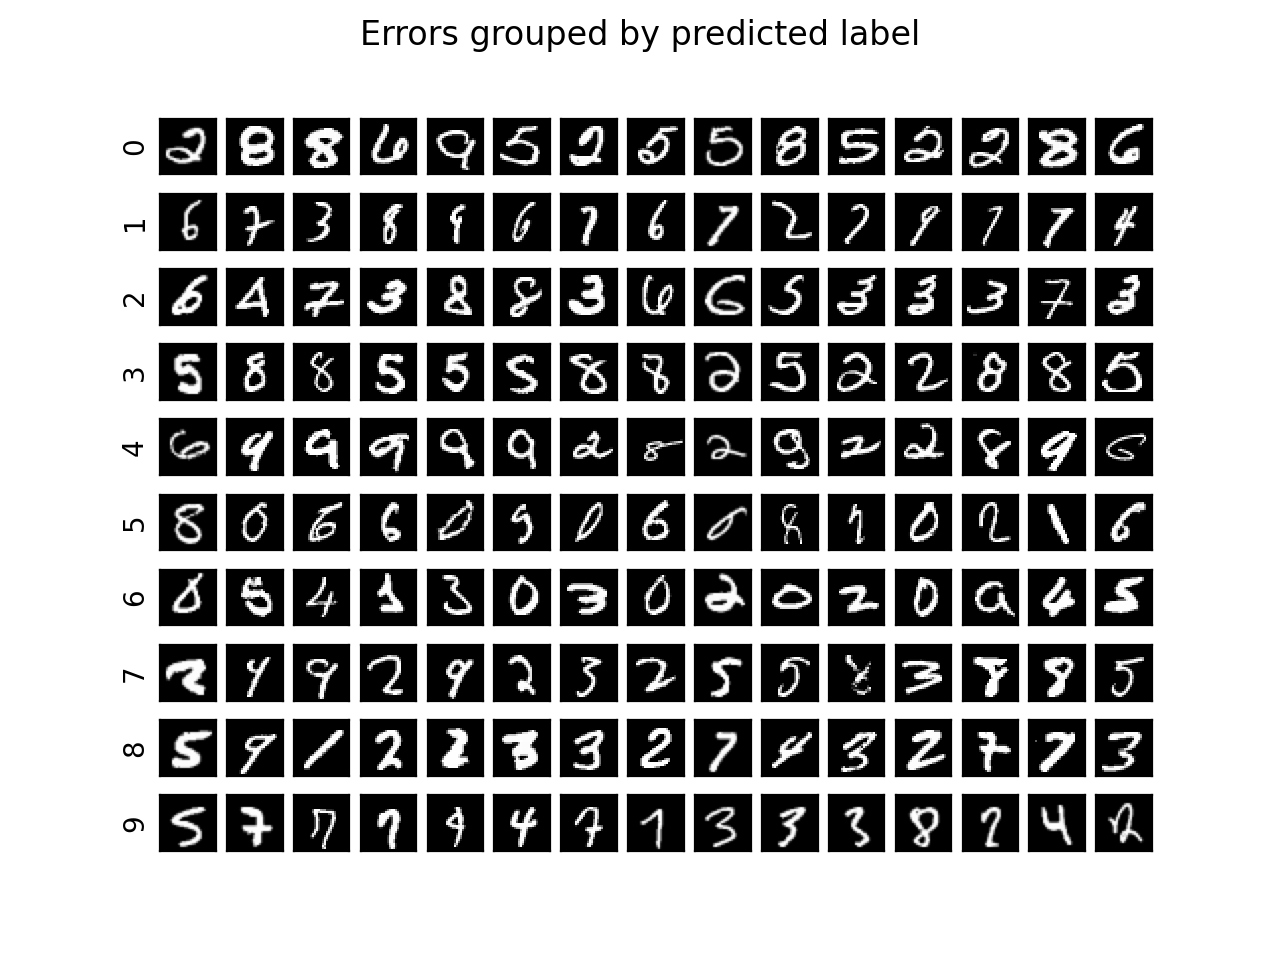

Text(0.5, 0.98, 'Errors grouped by predicted label')

In [184]:
# do the same, but this time show wrong predicitions only
perror = ytest != yhat
nextplot()
showdigits(Xtest[perror, :], yhat[perror])
plt.suptitle("Errors grouped by predicted label")

<IPython.core.display.Javascript object>


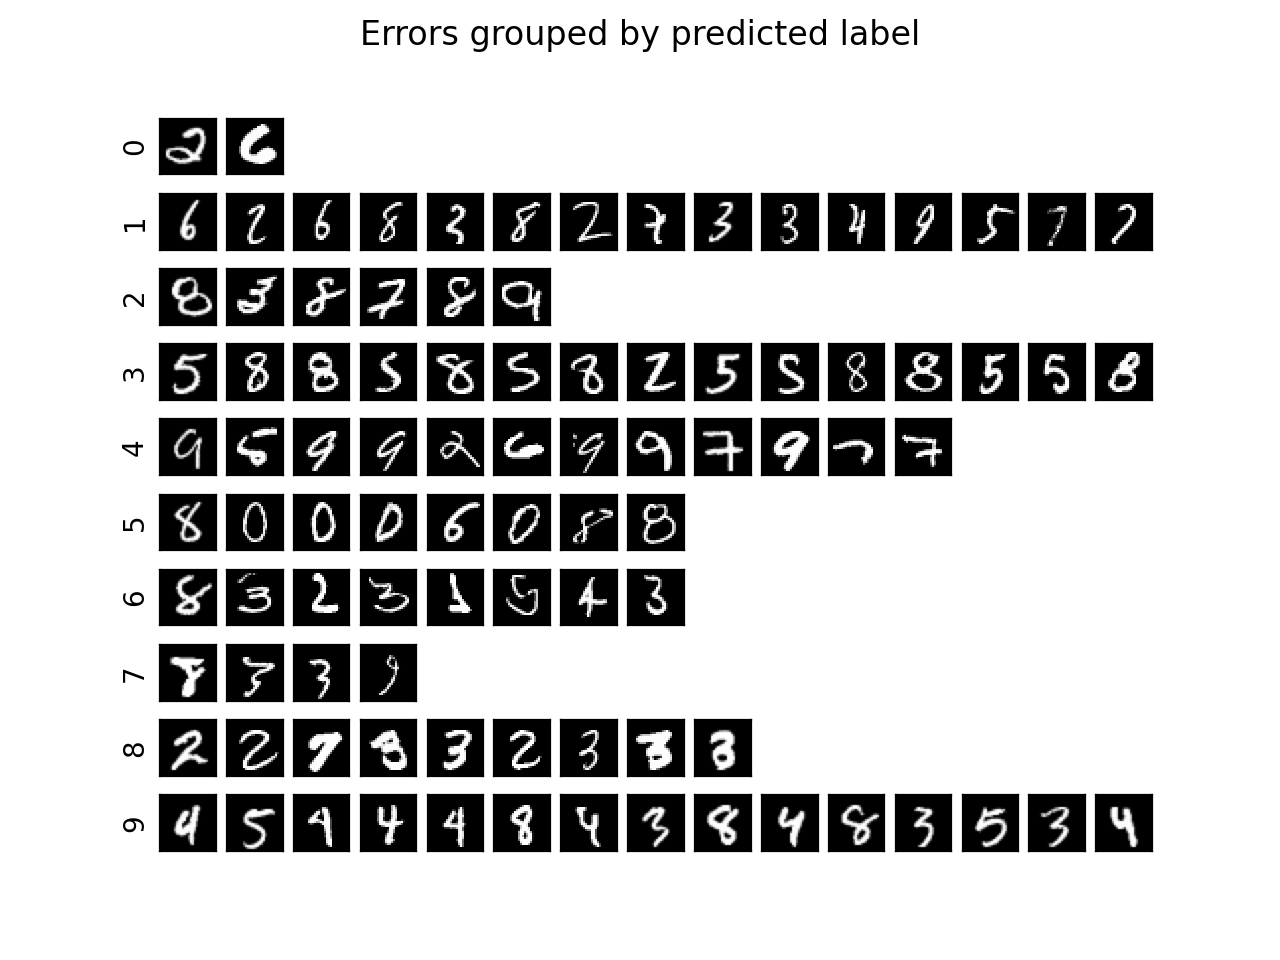

Text(0.5, 0.98, 'Errors grouped by predicted label')

In [185]:
# do the same, but this time on a sample of wrong preditions to see
# error proportions
ierror_s = np.random.choice(np.where(perror)[0], 100, replace=False)
nextplot()
showdigits(Xtest[ierror_s, :], yhat[ierror_s])
plt.suptitle("Errors grouped by predicted label")

In [170]:
# now let's look at this in more detail
print(sklearn.metrics.classification_report(ytest, yhat))
print(sklearn.metrics.confusion_matrix(ytest, yhat))  # true x predicted

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       980
           1       0.86      0.97      0.91      1135
           2       0.89      0.79      0.84      1032
           3       0.77      0.83      0.80      1010
           4       0.82      0.82      0.82       982
           5       0.78      0.67      0.72       892
           6       0.88      0.89      0.89       958
           7       0.91      0.84      0.87      1028
           8       0.79      0.78      0.79       974
           9       0.75      0.85      0.80      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.84      0.84     10000

[[ 872    0    3    5    3   63   18    1   14    1]
 [   0 1102    8    3    0    3    4    0   15    0]
 [  15   28  816   37   26    8   31   18   49    4]
 [   4   22   28  835    1   29   10   14   45   22]
 [   2    8    6    1  808   

<IPython.core.display.Javascript object>


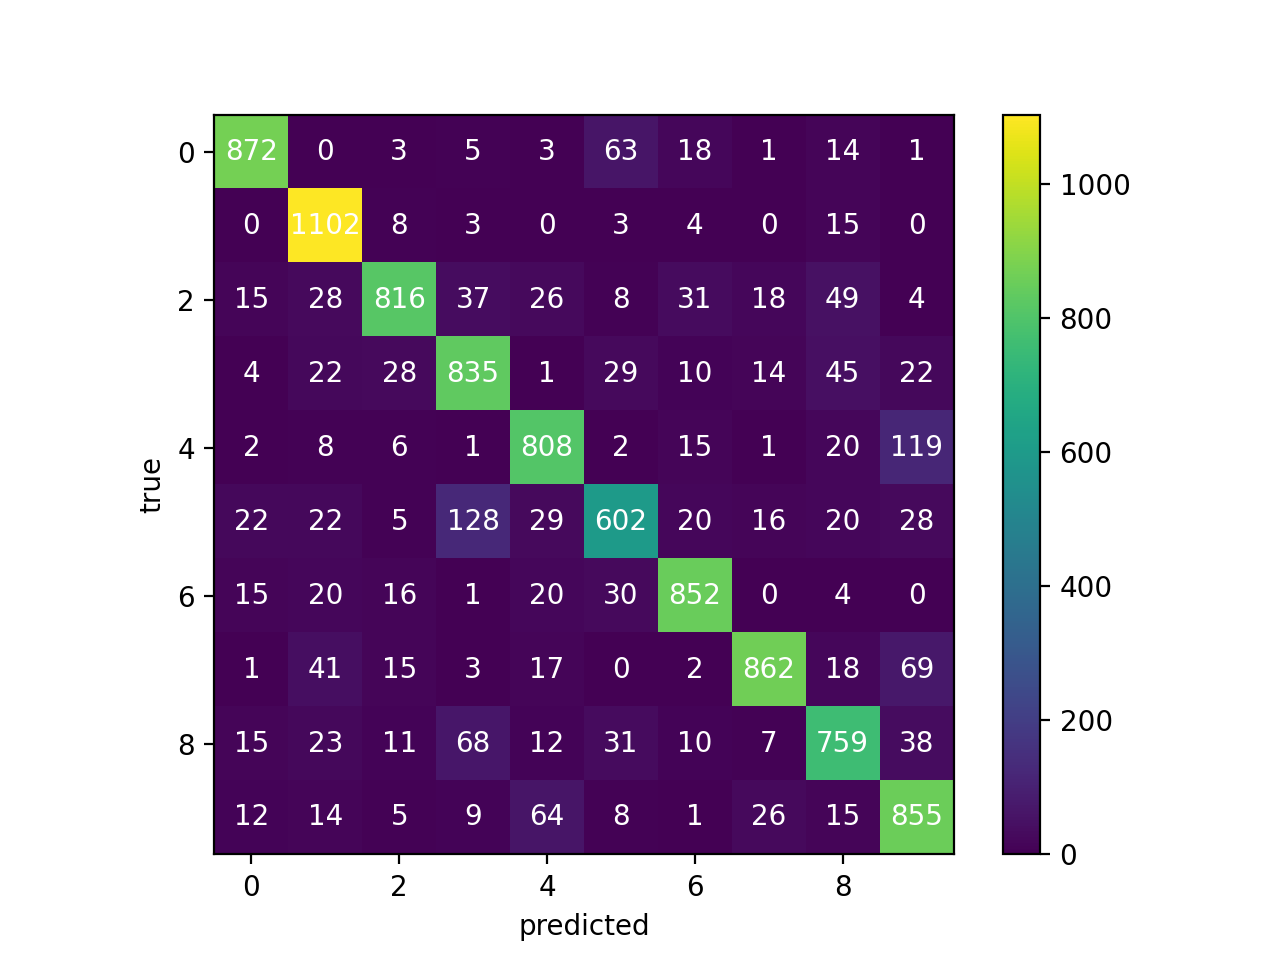

In [186]:
# plot the confusion matrix
nextplot()
M = sklearn.metrics.confusion_matrix(ytest, yhat)
plt.imshow(M, origin="upper")
for ij, v in np.ndenumerate(M):
    i, j = ij
    plt.text(j, i, str(v), color="white", ha="center", va="center")
plt.xlabel("predicted")
plt.ylabel("true")
plt.colorbar()

<IPython.core.display.Javascript object>


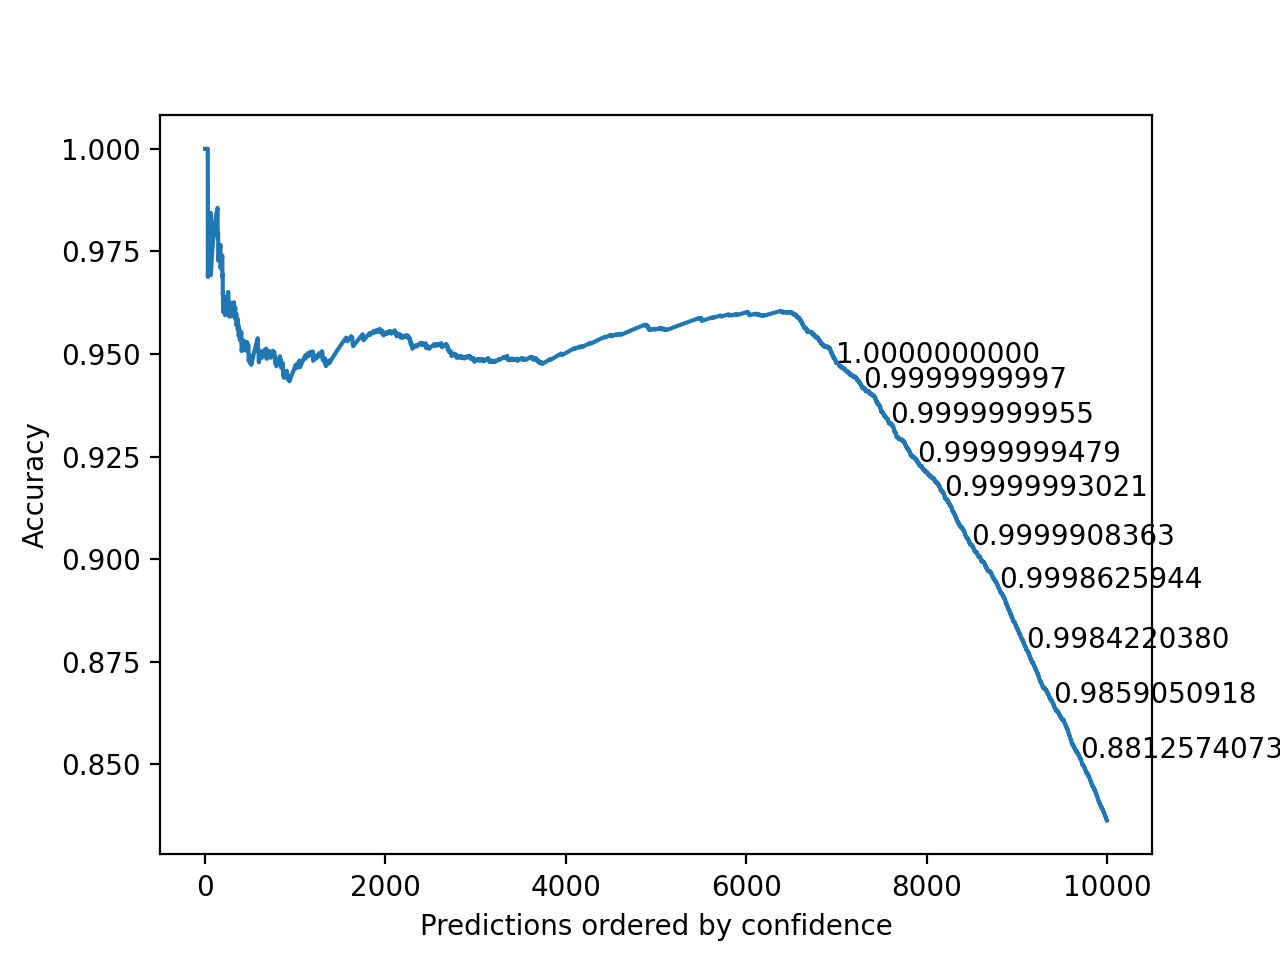

0.9999999999822649
0.9999999996949782
0.9999999955447265
0.9999999478873192
0.999999302093004
0.9999908362580441
0.9998625944161882
0.9984220379937705
0.9859050917807745
0.8812574072789097


In [187]:
# cumulative accuracy for predictions ordered by confidence (labels show predicted
# confidence)
order = np.argsort(logprob)[::-1]
accuracies = np.cumsum(ytest[order] == yhat[order]) / (np.arange(len(yhat)) + 1)
nextplot()
plt.plot(accuracies)
plt.xlabel("Predictions ordered by confidence")
plt.ylabel("Accuracy")
for x in np.linspace(0.7, 1, 10, endpoint=False):
    index = int(x * (accuracies.size - 1))
    print(np.exp(logprob[order][index]))
    plt.text(index, accuracies[index], "{:.10f}".format(np.exp(logprob[order][index])))
    

<IPython.core.display.Javascript object>


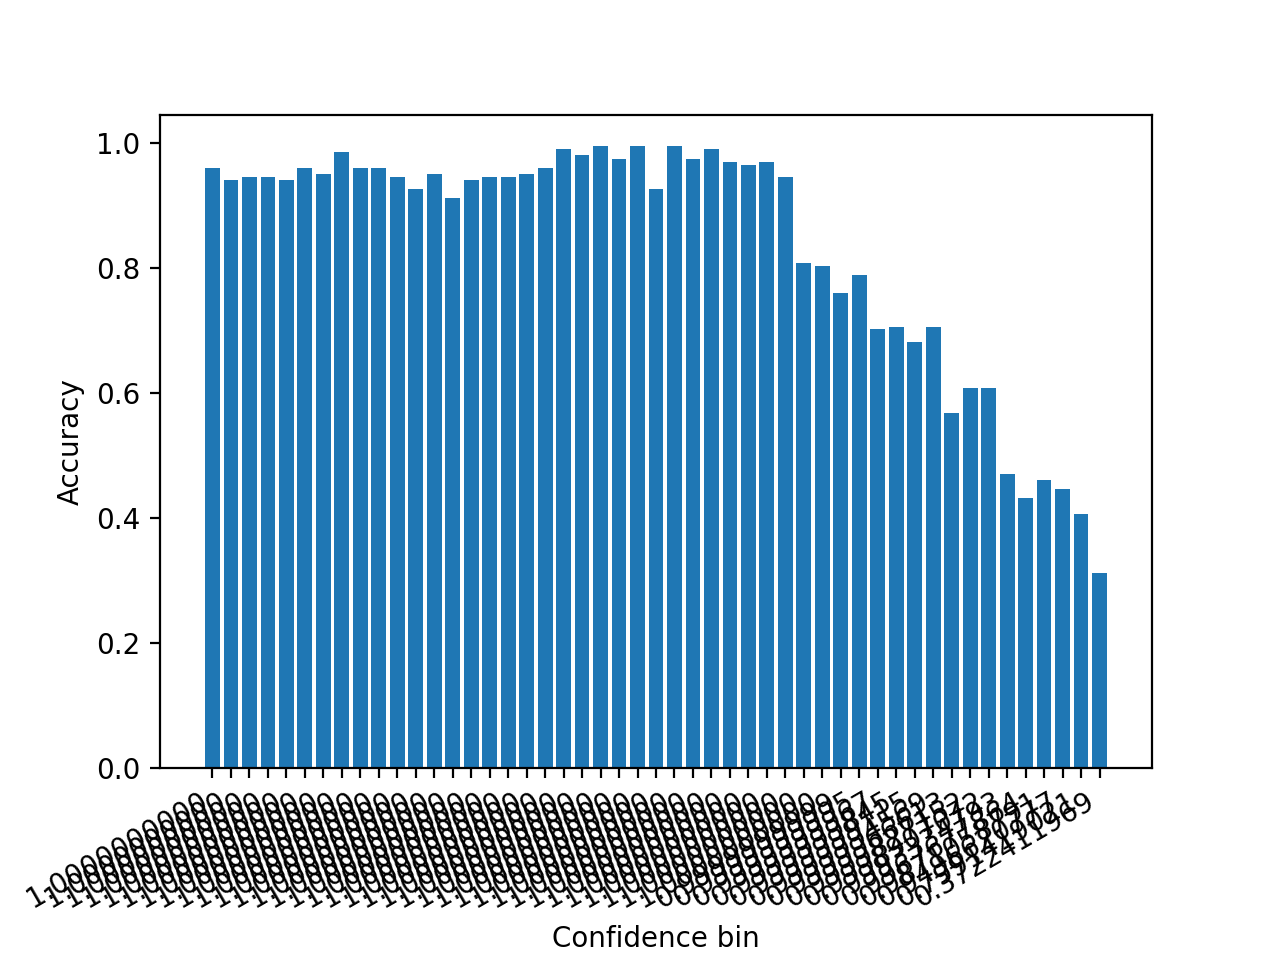

Text(0, 0.5, 'Accuracy')

In [188]:
# Accuracy for predictions grouped by confidence (labels show
# predicted confidence). Make the plot large (or reduce number of bins) to see
# the labels.
bins = (np.linspace(0, 1, 50) * len(yhat)).astype(int)
mean_accuracy = [
    np.mean(ytest[order][bins[i] : bins[i + 1]] == yhat[order][bins[i] : bins[i + 1]])
    for i in range(len(bins) - 1)
]
nextplot()
plt.bar(np.arange(len(mean_accuracy)), mean_accuracy)
plt.xticks(
    np.arange(len(mean_accuracy)),
    [
        "{:.10f}".format(x)
        for x in np.exp(logprob[order][np.append(bins[1:-1], len(yhat) - 1)])
    ],
)
plt.gcf().autofmt_xdate()
plt.xlabel("Confidence bin")
plt.ylabel("Accuracy")

# 4 Model Selection (optional)

In [174]:
# To create folds, you can use:
K = 5
Kf = KFold(n_splits=K, shuffle=True)
for train_index, test_index in Kf.split(X):
    # code here is executed K times, once per test fold
    # i_train has the row indexes of X to be used for training
    # i_test has the row indexes of X to be used for testing

    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


TRAIN: [    0     1     3 ... 59997 59998 59999] TEST: [    2     5    10 ... 59985 59987 59989]
TRAIN: [    0     1     2 ... 59993 59994 59996] TEST: [    3     7     8 ... 59997 59998 59999]
TRAIN: [    0     2     3 ... 59997 59998 59999] TEST: [    1     9    13 ... 59991 59992 59996]
TRAIN: [    0     1     2 ... 59997 59998 59999] TEST: [    4    17    20 ... 59983 59988 59993]
TRAIN: [    1     2     3 ... 59997 59998 59999] TEST: [    0     6    19 ... 59984 59986 59994]


In [175]:
# Use cross-validation to find a good value of alpha. Also plot the obtained
# accuracy estimate (estimated from CV, i.e., without touching test data) as a
# function of alpha.

In [ ]:
# playing around with different values of alpha to confirm my suspicion that for
# increases of alpha, the accuracy decreases ()
for i in range(3): 
    m = nb_train(X, y, alpha=i)
    p_m = nb_predict(m, Xtest)
    yhat_loop = p_m["yhat"]
    logprob_loop = p_m["logprob"]
    print("Accuracy of alpha=" + str(i) + " is " + str(sklearn.metrics.accuracy_score(ytest, yhat_loop)))

# 5 Generating Data

In [177]:
def nb_generate(model, ygen):
    """Given a Naive Bayes model, generate some data.

    Parameters
    ----------
    model : dict
        A Naive Bayes model trained with nb_train.
    ygen : nd_array of shape (n,)
        Vector of class labels for which to generate data.

    Returns
    -------
    nd_array of shape (n,D)

    Generated data. The i-th row is a sampled data point for the i-th label in
    ygen.
    """
    logcls = model["logcls"]
    n = len(ygen)
    C, D, K = logcls.shape
    Xgen = np.zeros((n, D))
    for i in range(n):
        c = ygen[i]
        # Generate the i-th example of class c, i.e., row Xgen[i,:]. To sample
        # from a categorical distribution with parameter theta (a probability
        # vector), you can use np.random.choice(range(K),p=theta).
        for d in range(D):
            Xgen[i][d] = np.random.choice(range(K), p = np.exp(logcls[c][d]))
            
    return Xgen

In [178]:
# generating digits for alpha = 1
model = nb_train(X, y, alpha=1)

<IPython.core.display.Javascript object>


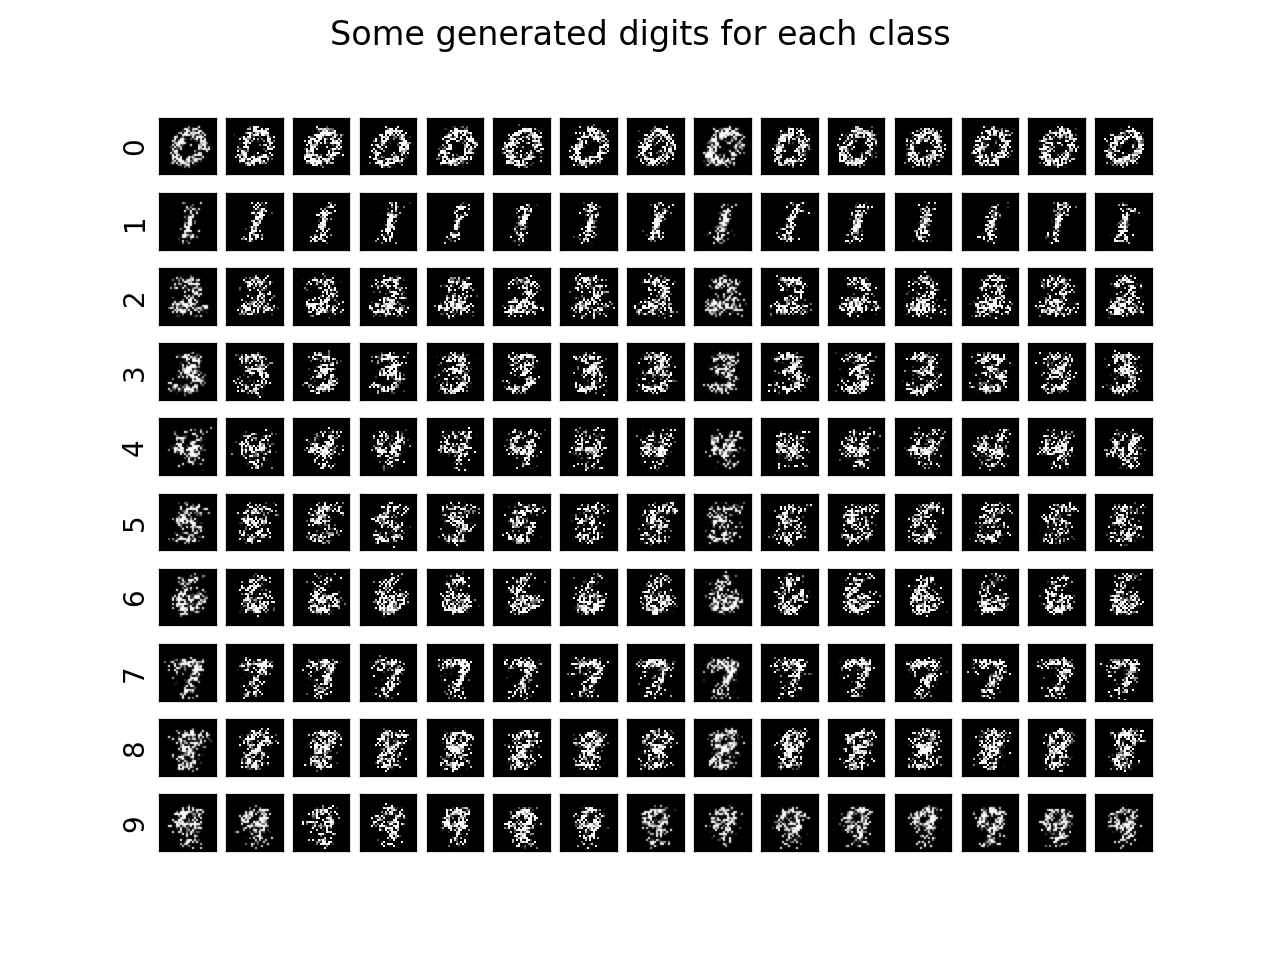

Text(0.5, 0.98, 'Some generated digits for each class')

In [179]:
# generating examples with alpha=1
ygen = np.repeat(np.arange(10), 15)
Xgen = nb_generate(model, ygen)

nextplot()
showdigits(Xgen, ygen)
plt.suptitle("Some generated digits for each class")

<IPython.core.display.Javascript object>


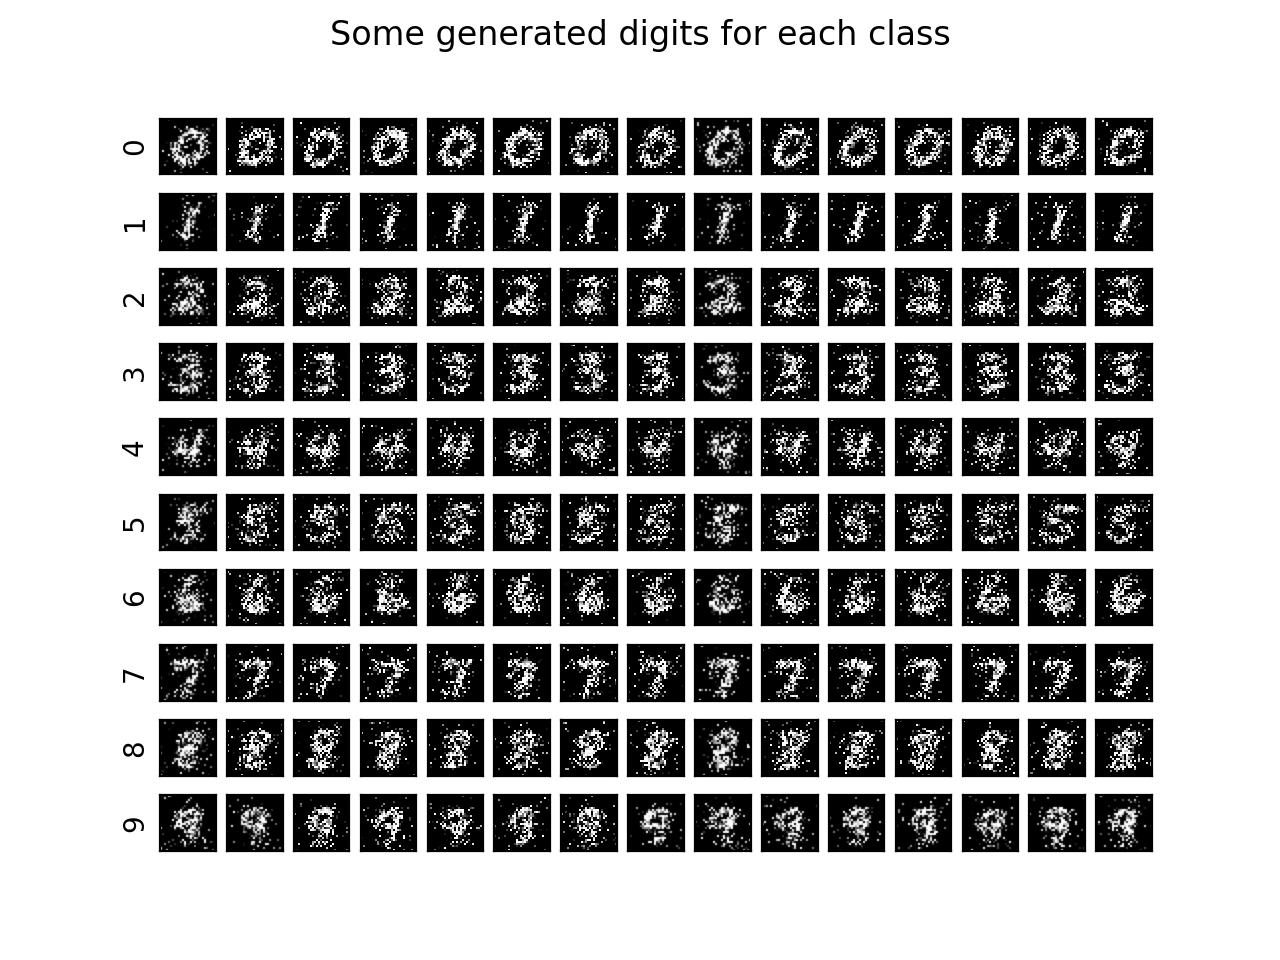

Text(0.5, 0.98, 'Some generated digits for each class')

In [180]:
# generating digits with alpha = 2
ygen = np.repeat(np.arange(10), 15)
Xgen = nb_generate(model_nb2, ygen)

nextplot()
showdigits(Xgen, ygen)
plt.suptitle("Some generated digits for each class")

<IPython.core.display.Javascript object>


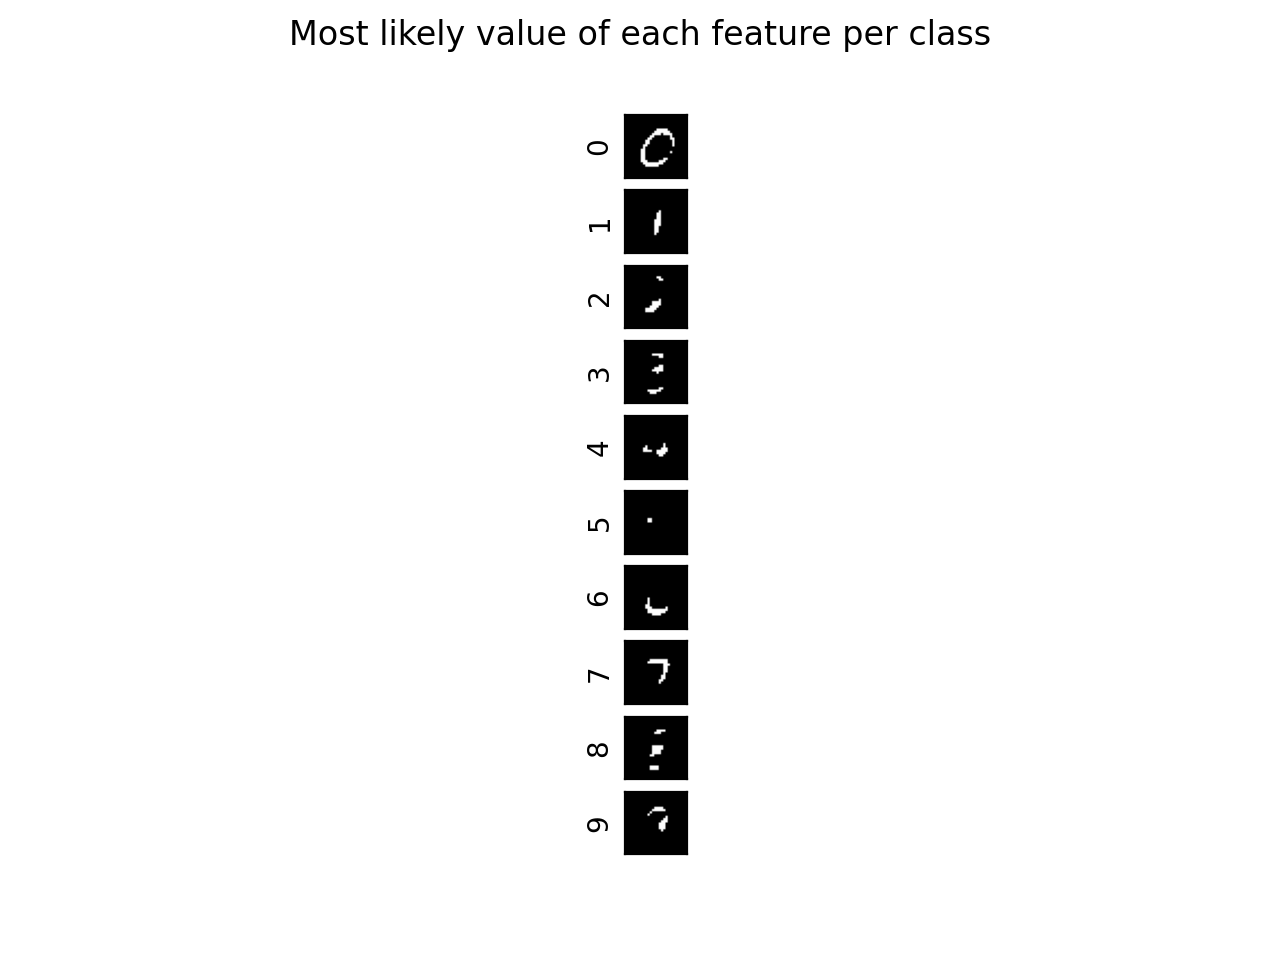

Text(0.5, 0.98, 'Most likely value of each feature per class')

In [181]:
# we can also plot the parameter vectors by choosing the most-likely
# value for each feature
ymax = np.arange(10)
Xmax = np.zeros((10, D))
for c in range(10):
    Xmax[c,] = np.apply_along_axis(np.argmax, 1, model_nb2["logcls"][c, :, :])

nextplot()
showdigits(Xmax, ymax)
plt.suptitle("Most likely value of each feature per class")

<IPython.core.display.Javascript object>


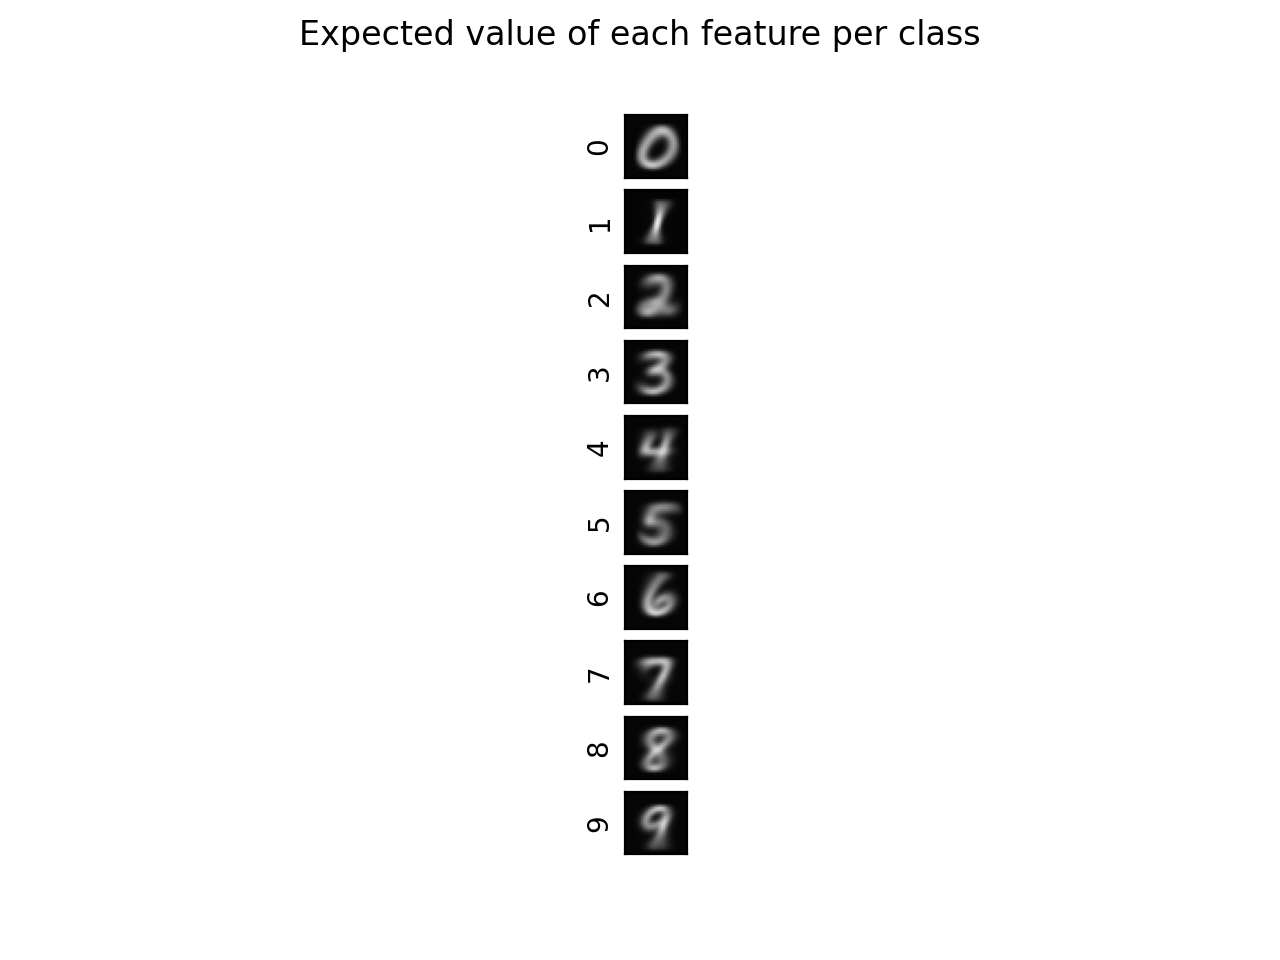

Text(0.5, 0.98, 'Expected value of each feature per class')

In [182]:
# Or the expected value of each feature. Here we leave the categorical domain
# and treat each feature as a number, i.e., this is NOT how categorical Naive
# Bayes sees it and we wouldn't be able to do this if the data were really
# categorical.
ymean = np.arange(10)
Xmean = np.zeros((10, D))
for c in range(10):
    Xmean[c,] = np.apply_along_axis(
        np.sum, 1, np.exp(model_nb2["logcls"][c, :, :]) * np.arange(256)
    )

nextplot()
showdigits(Xmean, ymean)
plt.suptitle("Expected value of each feature per class")